In [3]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)



Global seed set to 0


In [4]:
import pertpy

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [5]:
# import from scfair-reproducibility
from dis2pm_dev.scfair_reproducibility.benchmark_VAE.vi import VI
from dis2pm_dev.scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from dis2pm_dev.scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker


In [2]:
from dis2p.dis2pvae import *
from dis2p.dis2pvi import *
from dis2p.ood import *
from dis2p.trainingplan import *
from dis2p.utils import *

import dis2p.dis2pvae_cE as dvae
import dis2p.dis2pvi_cE as dvi

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_13/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


## Train Dis2p

In [7]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

# preprocess dataset
adata = pertpy.data.kang_2018() #scvi.data.heart_cell_atlas_subsampled()
#adata = sc.read("/nfs/team205/sm58/packages/dis2p_trials/scfair/data/hca_subsampled_20k.h5ad")
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'KangBlood'

# specify attributes
cats = ['label', 'cell_type']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [18]:
# train params
epochs = 300
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p_saveBest'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'Best,{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:
    Dis2pVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = Dis2pVI(adata, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     No backup URL provided for missing file                                                                   
         models/dis2p_saveBest/Best,2024-01-16,dis2p_saveBest,KangBlood,n_layers=1,max_epochs=300,batch_size=128,cf
         _weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt                             


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57/300:  19%|▏| 56/300 [14:23<1:07:12, 16.53s/it, v_num=1, loss_validation=1.06e+3, x_0_validation=210, x_1_validation=214, x_2_validation=215, rec_x_cf_validation=333, z_1_validation=17, Epoch 00057: reducing learning rate of group 0 to 6.0000e-04.
Epoch 71/300:  24%|▏| 71/300 [18:23<59:19, 15.54s/it, v_num=1, loss_validation=1.06e+3, x_0_validation=210, x_1_validation=214, x_2_validation=216, rec_x_cf_validation=332, z_1_validation=14.4, 
Monitored metric loss_validation did not improve in the last 45 records. Best score: 1050.765. Signaling Trainer to stop.


In [19]:
# load model
pre_path = f'models/dis2p_saveBest'
model_name =  f'Best,{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())
model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)



INFO     File                                                                                                      
         models/dis2p_saveBest/Best,2024-01-16,dis2p_saveBest,KangBlood,n_layers=1,max_epochs=300,batch_size=128,cf
         _weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded          


In [20]:
adata.obsm[f'{module_name}'] = model.get_latent_representation(adata, nullify_cat_covs_indices=[0], nullify_shared=True)


In [21]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
#warnings.simplefilter('ignore', category=NumbaWarning)

---UMAP for dis2p_Z_0---


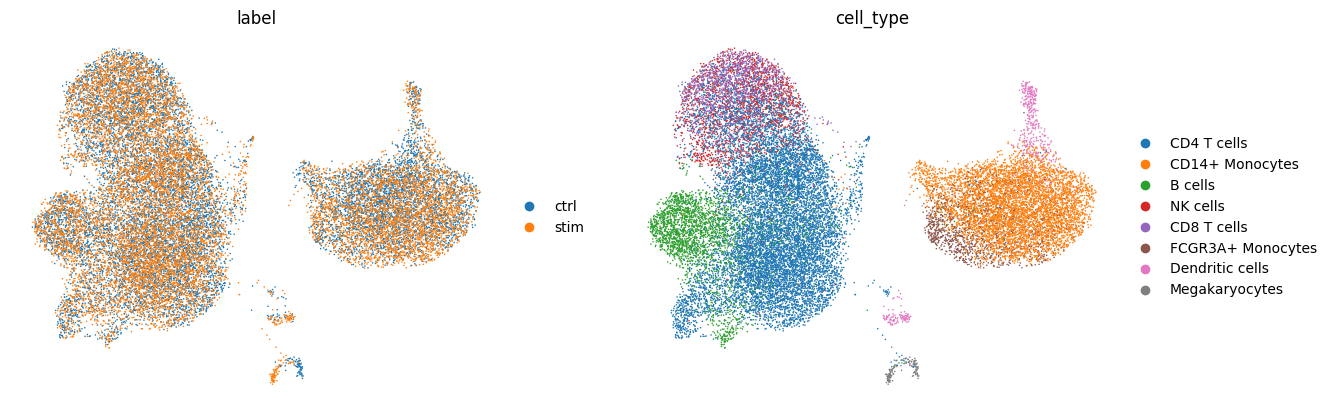

---UMAP for dis2p_Z_1---


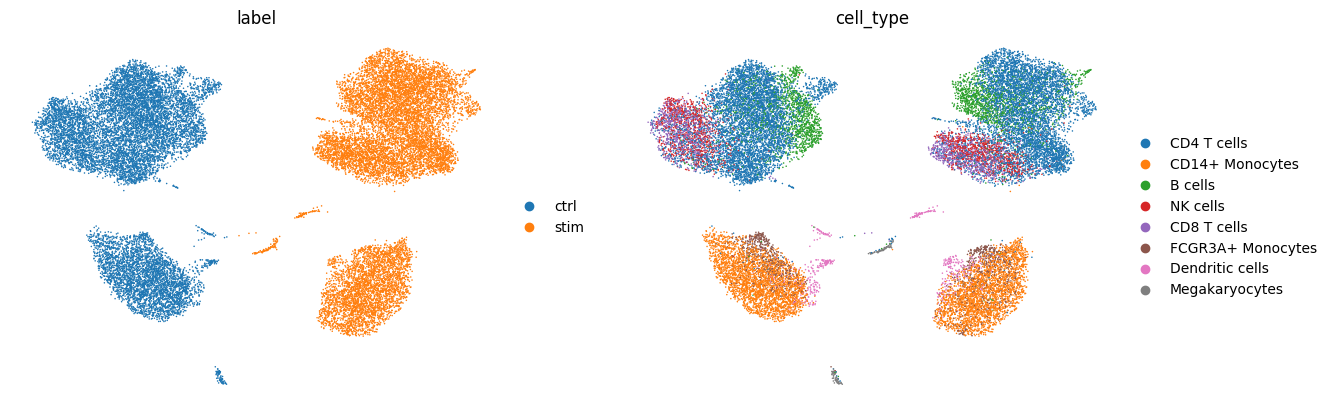

---UMAP for dis2p_Z_2---


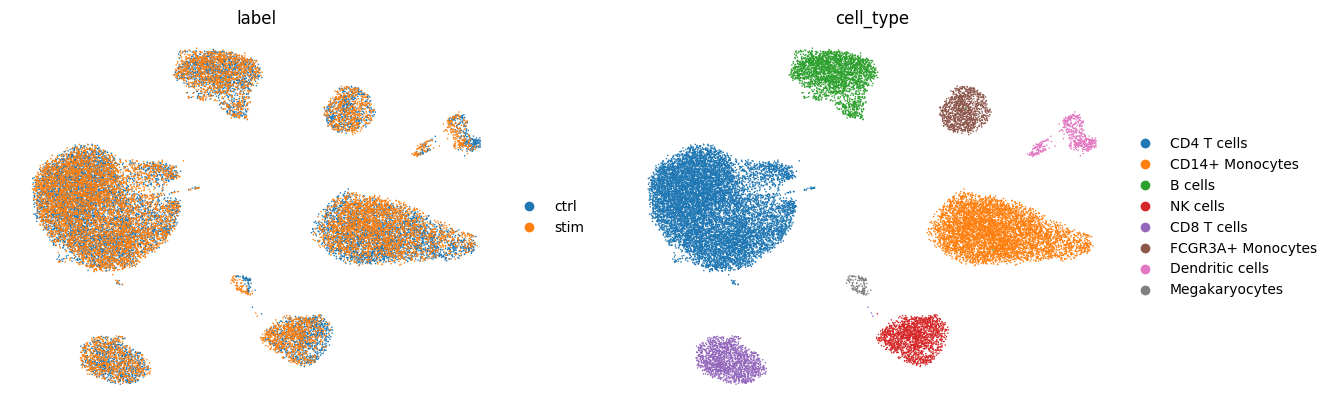

In [22]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## Train dis2p_cE version

In [33]:
module_name = 'dis2p_cE'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:
    dvi.Dis2pVI_cE.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = dvi.Dis2pVI_cE(adata, n_layers=n_layers)
    model.train(**train_dict)


INFO     File                                                                                                      
         models/dis2p_cE/2024-01-16,dis2p_cE,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,c
         lf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                            


In [19]:
model.save(f"{pre_path}/{model_name}")

In [20]:
# load model
model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)



INFO     File                                                                                                      
         models/dis2p_cE/2024-01-16,dis2p_cE,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,c
         lf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                            


In [34]:
adata.obsm[f'{module_name}'] = model.get_latent_representation(adata, nullify_cat_covs_indices=[0], nullify_shared=True)


---UMAP for dis2p_cE_Z_0---


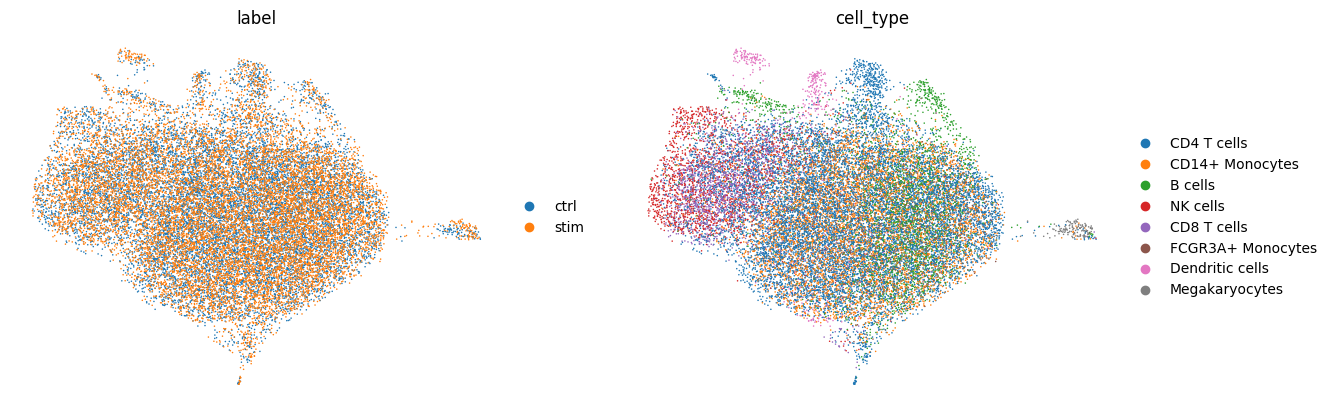

---UMAP for dis2p_cE_Z_1---


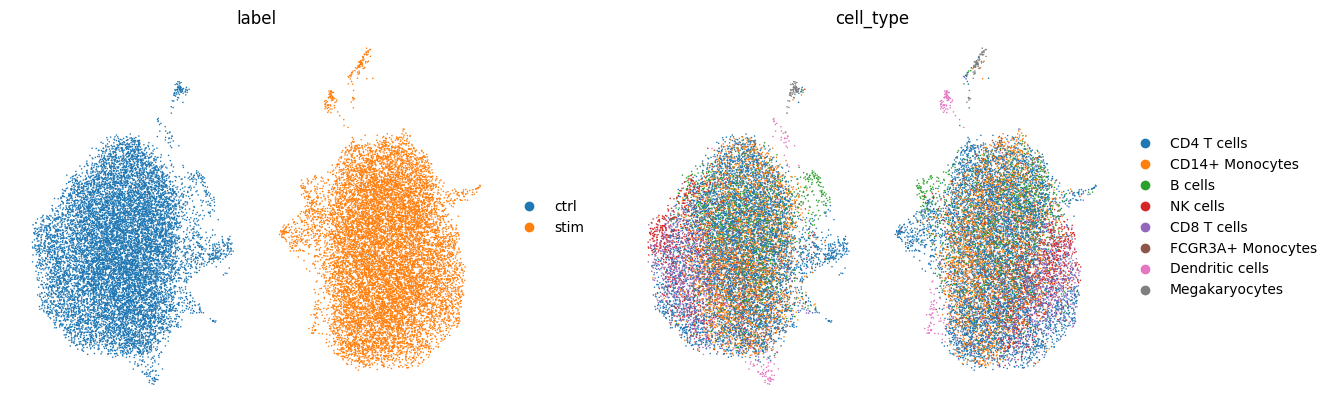

---UMAP for dis2p_cE_Z_2---


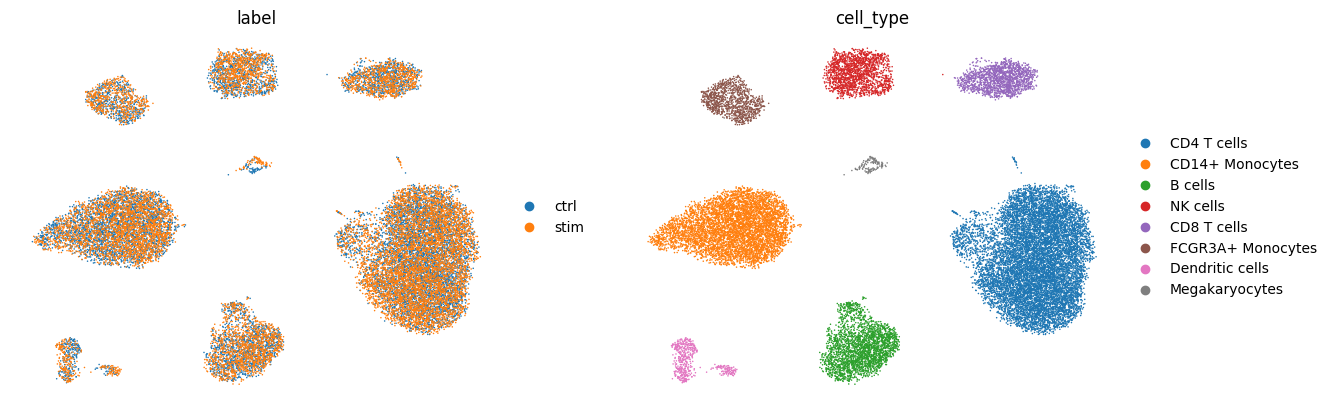

In [21]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## We notice that the UMAP of save best is much worse than dis2p w/0 save best.

# History plots of save_best dis2p


INFO     File                                                                                                      
         models/dis2p/2024-01-16,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_wei
         ght=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                  


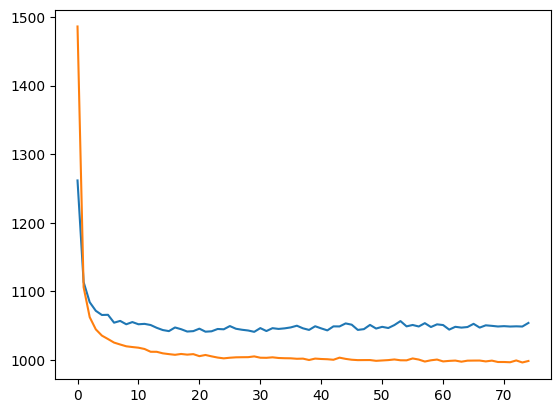

In [8]:
model_name =  'models/dis2p/2024-01-16,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = Dis2pVI.load(model_name, adata=adata)
plt.plot(model.history['loss_validation'])
plt.plot(model.history['loss_train'])



INFO     File                                                                                                      
         models/dis2p/2024-01-16,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_wei
         ght=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                  


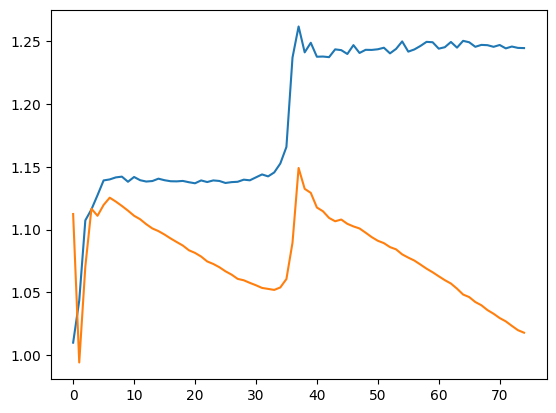

In [35]:
# plt.plot(model.history['loss_validation'])
# plt.plot(model.history['loss_train'])
model_name =  'models/dis2p/2024-01-16,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = Dis2pVI.load(model_name, adata=adata)

plt.plot(model.history['adv_ce_validation'])
plt.plot(model.history['adv_ce_train'])


INFO     File                                                                                                      
         models/dis2p_saveBest/Best,2024-01-16,dis2p_saveBest,KangBlood,n_layers=1,max_epochs=300,batch_size=128,cf
         _weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded          


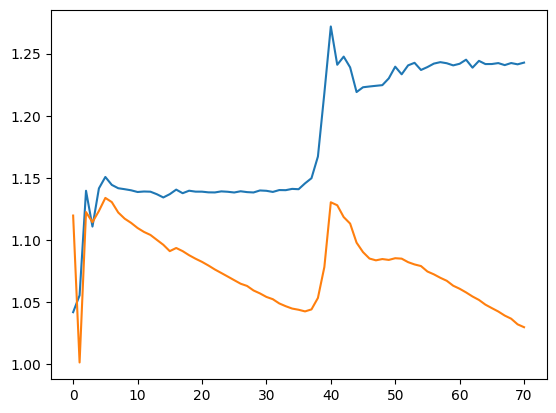

In [36]:
model_name =  "models/dis2p_saveBest/Best,2024-01-16,dis2p_saveBest,KangBlood,n_layers=1,max_epochs=300,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1"
model = Dis2pVI.load(model_name, adata=adata)
plt.plot(model.history['adv_ce_validation'])
plt.plot(model.history['adv_ce_train'])

